In [4]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [5]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (150,150)

In [6]:
def load_data():

    datasets = ['/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN','/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST' ]
    images = []
    labels = []

    # iterate through training and test sets
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the| img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [7]:
images, labels = load_data()

100%|██████████| 623/623 [00:03<00:00, 164.17it/s]


In [8]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

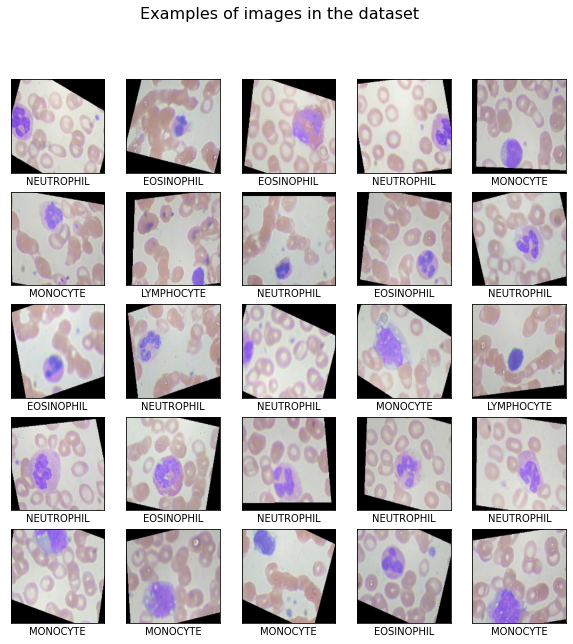

In [9]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionResNetV2



model=InceptionResNetV2(weights='imagenet',include_top=False, input_shape = (150,150,3))
x = layers.Flatten()(model.output)
output = layers.Dense(4, activation='softmax')(x)
model = Model(model.input, output)


model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 74, 74, 32)   96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 74, 74, 32)   0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

In [12]:
checkpoint = ModelCheckpoint(filepath='inception_best.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose = 1, mode='min', restore_best_weights = True)


learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history1 = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 25, 
    validation_data=(val_images, val_labels),
    callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
312/312 [==============================] - 83s 189ms/step - loss: 0.7916 - accuracy: 0.7730 - val_loss: 0.6549 - val_accuracy: 0.8265
Epoch 2/25
312/312 [==============================] - 54s 175ms/step - loss: 0.4155 - accuracy: 0.8870 - val_loss: 0.4020 - val_accuracy: 0.8835
Epoch 3/25
312/312 [==============================] - 55s 175ms/step - loss: 0.1156 - accuracy: 0.9566 - val_loss: 0.1346 - val_accuracy: 0.9550
Epoch 4/25
312/312 [==============================] - 54s 174ms/step - loss: 0.0427 - accuracy: 0.9846 - val_loss: 0.0266 - val_accuracy: 0.9896
Epoch 5/25
312/312 [==============================] - 54s 174ms/step - loss: 0.0208 - accuracy: 0.9927 - val_loss: 0.1726 - val_accuracy: 0.9622
Epoch 6/25
312/312 [==============================] - 54s 172ms/step - loss: 0.1887 - accuracy: 0.9593 - val_loss: 0.0828 - val_accuracy: 0.9655

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/25
312/312 [=============================

In [14]:
model.evaluate(test_images, test_labels)

39/39 [==============================] - 2s 63ms/step - loss: 0.0188 - accuracy: 0.9944


[0.01875772513449192, 0.9943729639053345]

In [ ]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(25)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

In [ ]:
plot_accuracy_loss_chart(history1)

In [15]:
model.save("inceptionResNet.h5")

In [ ]:
# Evaluating the model on the test data

results = model.evaluate(test_images, test_labels)

print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

In [16]:
# Create predictions for test images

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([0, 2, 2, 3, 2, 2, 1, 1, 3, 1, 1, 2, 0, 3, 1])

In [17]:
from sklearn.metrics import classification_report

print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.98      1.00      0.99       302
LYMPHOCYTE (Class 1)       1.00      1.00      1.00       311
  MONOCYTE (Class 2)       1.00      1.00      1.00       311
NEUTROPHIL (Class 3)       1.00      0.98      0.99       320

            accuracy                           0.99      1244
           macro avg       0.99      0.99      0.99      1244
        weighted avg       0.99      0.99      0.99      1244



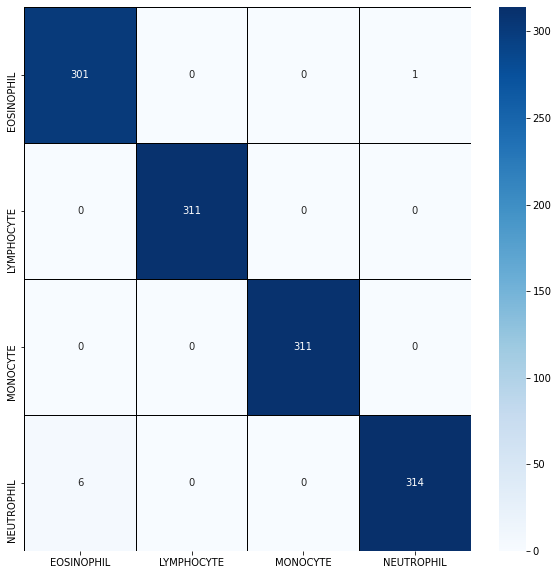

In [18]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)